In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def get_waiting_time(min_wait_time, anom_diff_exp,check=0):
    
    R = np.random.uniform(0,1)
    waiting_time = min_wait_time / (R**(1/anom_diff_exp))
    
    return waiting_time

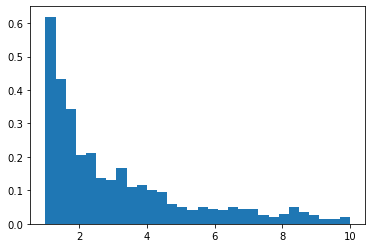

In [6]:
def check_waiting_times(nsamples,alpha,min_waiting_time=1):
    # plotting probability distribution of waiting times as a check
    waiting_times = np.empty((nsamples))
    for i in range(nsamples):
        waiting_times[i] = get_waiting_time(min_waiting_time, alpha)
    plt.hist(waiting_times, bins=30, range=(1, 10), density=True)
    
check_waiting_times(1000,0.5)

In [7]:
def gaussian_step(D, t, ndim=1):
    
    var = 2*ndim*D*t
    dx = np.random.normal(scale=np.sqrt(var))
    return dx

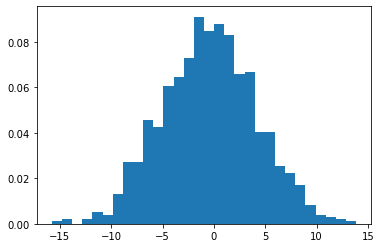

In [8]:
def check_steps(nsamples,D_coeff,t):
    # plotting probability distribution of step lengths as a check

    step_lengths = np.empty((nsamples))
    for i in range(nsamples):
        step_lengths[i] = gaussian_step(D_coeff, t)
    plt.hist(step_lengths, bins=30, density=True)
    
check_steps(1000,10,1)

In [9]:
# CTRW for single particle in 1D
def ctrw(x_start, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,plot=0):
    """
    Be consistent with units
    run_time: simulation time 
    diff_time: diffusion time
    min_wait_time: minimum waiting time
    """
    time = 0
    x = x_start
    times = np.array([time])
    xs = np.array([x])
    while time < run_time:
        waiting_time = get_waiting_time(min_wait_time, anom_diff_exp)
        time += waiting_time  # update current time
        times = np.append(times, time)
        xs = np.append(xs, xs[-1])
        x += gaussian_step(diff_coeff, diff_time)  # update current x position
        times = np.append(times, time)
        xs = np.append(xs, x)
    
    times = times[:-1]
    xs = xs[:-1]
    
    times = np.append(times, run_time)
    xs = np.append(xs, xs[-1])
    
    data = {'t': times, 'x': xs}
    df = pd.DataFrame(data)
    if plot==1:
        plt.plot(df['t'], df['x'])
    return df

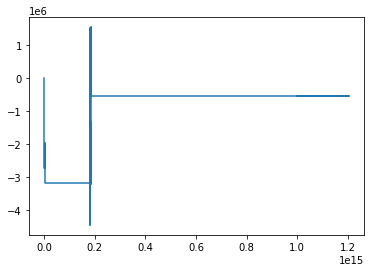

In [10]:
# what units is DaMaRiS diffusion coefficient in?
# times in ps:
df = ctrw(0, 2.8e11, 1, 1e15, 1e9, 0.5,plot=1)

In [11]:
def ctrw_3d(initial_position, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,plot=0):
    """
    """
    time = 0
    x, y, z = initial_position
    times = np.array([time])
    xs = np.array([x])
    ys = np.array([y])
    zs = np.array([z])
    
    while time < run_time:
        waiting_time = get_waiting_time(min_wait_time, anom_diff_exp)
        time += waiting_time  # update current time
        times = np.append(times, time)
        xs = np.append(xs, xs[-1])
        ys = np.append(ys, ys[-1])
        zs = np.append(zs, zs[-1])
        x += gaussian_step(diff_coeff, diff_time)  # update current x position
        y += gaussian_step(diff_coeff, diff_time)  # update current y position
        z += gaussian_step(diff_coeff, diff_time)  # update current z position
        times = np.append(times, time)
        xs = np.append(xs, x)
        ys = np.append(ys, y)
        zs = np.append(zs, z)
    
    data = {'t': times, 'x': xs, 'y': ys, 'z': zs}
    df = pd.DataFrame(data)
                      
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df_3d['x'], df_3d['y'], df_3d['z'])
    return df

In [12]:
df_3d = ctrw_3d((0,0,0), 2.8e11, 1, 1e15, 1e9, 0.5)

In [137]:
def gauss_step_3d(xyz_array,diff_coeff, diff_time):
    
    new_coords = np.zeros(3)
    
    if len(xyz_array.flatten()) > 3:
        xyz_array_row = xyz_array[-1]
    else:
        xyz_array_row = xyz_array

    for i,x_i in enumerate(xyz_array_row):
        
        new_coords[i] = x_i + gaussian_step(diff_coeff,diff_time)
        
    xyz_array = np.vstack((xyz_array,new_coords))
    return xyz_array

def get_distance_3d(xyz_array1,xyz_array2):
    #function to get distance between two sets of coordinates
    
    distance = 0
    
    for i,x_i in enumerate(xyz_array1):
        
        distance += (x_i - (xyz_array2[i]))**2
        
    return np.sqrt(distance)

def interaction_process(p):
    #simple call to uniform function if within distance
    #could be altered to consider probability based on distance
    repair = 0 
    q = np.random.uniform(0,1)
    if q > p:
        repair = 1
    return repair

def get_halfway(xyz_array1,xyz_array2):
    
    halfway_coords = np.empty(3)
    
    for i,x_i in enumerate(xyz_array1):
        
        halfway_coords[i] = (x_i + xyz_array2[i])/2
        
    return halfway_coords


In [138]:
def ctrw_3d_interaction(initial_pos,diff_coeff,diff_time,run_time,min_wait_time,anom_diff_exp,
                        int_length,interaction_p=0.5,plot=0):
    """
    """
    repair = 0 
    time1 = 0
    time2 = 0 
    
    x1, y1, z1 = initial_pos[0]
    x2, y2, z2 = initial_pos[1]
    
    times1 = np.array([time1])
    times2 = np.array([time2])
    
    coords1 = np.array([x1, y1, z1])
    coords2 = np.array([x2, y2, z2])
    
    interaction_coords = np.array([0,0,0,0,0,0])
    interaction_times = np.array([0,0])
    interaction_count = 0
    int_count_arr = np.array(interaction_count)
    repair_arr = np.array([repair])

    while (time1 < run_time or time2 < run_time) and repair ==0:
        waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
        waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        
        time1 += waiting_time1  # update current time
        times1 = np.append(times1, time1)
        
        time2 += waiting_time2  # update current time
        times2 = np.append(times2, time2)

        coords1 = gauss_step_3d(coords1,diff_coeff, diff_time)
        coords2 = gauss_step_3d(coords2,diff_coeff, diff_time)
        
        distance = get_distance_3d(coords1[-1],coords2[-1])
        
        if distance < int_length:
            
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            
            if interaction_count == 1:
                interaction_times = np.array([time1,time2])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([time1,time2])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)


    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    
    """
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.scatter(df1['x'].iloc[0], df1['y'].iloc[0], df1['z'].iloc[0],marker='x',c='k')
        ax.scatter(df2['x'].iloc[0], df2['y'].iloc[0], df2['z'].iloc[0],marker='x',c='k')
        
        if interaction_count > 1:
            ax.scatter(interaction_coords[:-1,0],interaction_coords[:-1,1],
                       interaction_coords[:-1,2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-1,0],interaction_coords[-1,1],
                       interaction_coords[-1,2],c='r')
                
        elif interaction_count == 1:
            ax.scatter(interaction_coords[0],interaction_coords[1],
                       interaction_coords[2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-0],interaction_coords[1],
                       interaction_coords[2],c='r')
                       
    """
        
    return interaction_times,interaction_coords,int_count_arr,repair_arr
            

In [139]:
min_dist  = 1e7
ts,xyzs,counts,repair = ctrw_3d_interaction([(0,0,0),(0,0,min_dist*1)], 2.8e11, 1, 1e16, 1e9, 0.5,
                                   min_dist,interaction_p = 0.9,plot=1)

In [71]:
def ctrw_3d_interaction_mc(nsamples,initial_pos,diff_coeff,diff_time,run_time,min_wait_time,anom_diff_exp,
                        int_length,interaction_p=0.5,plot=0):
    
    j = 0
    
    for i in np.arange(nsamples):
        
        ts_temp,xyzs_temp,counts_temp,repair_temp = ctrw_3d_interaction(initial_pos, diff_coeff, diff_time, run_time, min_wait_time, 0.5,
                                                    int_length,interaction_p = 0.9,plot=1)
     
        repair_temp = np.reshape(repair_temp,(len(repair_temp),1))
        counts_temp = np.reshape(counts_temp,(np.size(counts_temp),1))
        
        if counts_temp[0] != 0:
        
            mc_sample = np.full((len(counts_temp),1),i)

            data_temp = np.hstack((mc_sample,ts_temp,xyzs_temp,counts_temp,repair_temp))

            if j == 0:

                repair_data = data_temp

            else: 

                repair_data = np.vstack((repair_data,data_temp))
                
            j+=1
                
    print(np.shape(repair_data))
    repair_df = pd.DataFrame(data=repair_data, columns=['mc_step', 't1', 't2','x1','y1','z1',
                                                        'x2','y2','z2','interaction','repair'])
    
            
    return repair_df


In [72]:
repair_data = ctrw_3d_interaction_mc(1000,[(0,0,0),(0,0,min_dist*1)], 2.8e11, 1, 1e16, 1e9, 0.5,
                                       min_dist,interaction_p = 0.9,plot=0)

(7409, 11)


(array([590., 331., 178., 130., 123.,  99.,  85., 120.,  87.,  82.,  52.,
         56.,  54.,  35.,  38.,  45.,  40.,  34.,  37.,  35.,  47.,  43.,
         35.,  38.,  32.,  33.,  39.,  27.,  26.,  22.,  24.,  19.,  22.,
         13.,  22.,  23.,  27.,   9.,  11.,  14.,  15.,  13.,  19.,  22.,
         21.,  14.,   9.,  12.,  25.,  28.,  23.,  15.,  23.,  15.,  16.,
         20.,  19.,  16.,  13.,  10.,  17.,   5.,  10.,  10.,   6.,   5.,
         15.,   4.,   8.,   5.,   9.,   3.,   2.,   6.,   6.,   7.,   5.,
          5.,   7.,   3.,   4.,   7.,  10.,  13.,   4.,  12.,   6.,   9.,
          1.,   8.,  11.,   5.,   2.,   2.,   5.,   2.,   4.,   4.,   4.,
          8.]),
 array([0.0e+00, 1.0e+10, 2.0e+10, 3.0e+10, 4.0e+10, 5.0e+10, 6.0e+10,
        7.0e+10, 8.0e+10, 9.0e+10, 1.0e+11, 1.1e+11, 1.2e+11, 1.3e+11,
        1.4e+11, 1.5e+11, 1.6e+11, 1.7e+11, 1.8e+11, 1.9e+11, 2.0e+11,
        2.1e+11, 2.2e+11, 2.3e+11, 2.4e+11, 2.5e+11, 2.6e+11, 2.7e+11,
        2.8e+11, 2.9e+11, 3.0e+11,

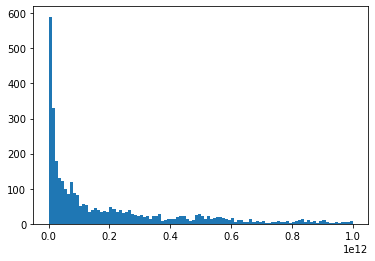

In [67]:
plt.hist(repair_data['t1'], bins=100, range=(0, 1e12))

In [146]:
def unit_vector_single():
    #Streamlined function to return only a single vector, distributed in the same manner as above.
    #Plotting of the above vectors in large quantity attest the validity of using this function.
    
    random_value_1 = np.random.uniform(0,1)
    random_value_2 = np.random.uniform(0,1)
    
    #ICDFs produced as before
    inclination = np.arccos(1-2*random_value_1)
    azimuth = 2*(np.pi)*random_value_2
    
    #cartesian conversion
    x = np.cos(azimuth)*np.sin(inclination)
    y = np.sin(azimuth)*np.sin(inclination)
    z = np.cos(inclination)
    
    return np.array([x,y,z])

def ctrw_3d_self_interaction(initial_pos,diff_coeff,diff_time,run_time,min_wait_time,anom_diff_exp,
                        int_length,strand_length,interaction_p=0.5,plot=0):
    """
    """
    repair = 0 
    time1 = 0
    time2 = 0 
    
    x1, y1, z1 = initial_pos
    
    x2, y2, z2 = initial_pos + strand_length*unit_vector_single()
    
    print(x2,y2,z2)
    
    times1 = np.array([time1])
    times2 = np.array([time2])
    
    coords1 = np.array([x1, y1, z1])
    coords2 = np.array([x2, y2, z2])
    
    interaction_coords = np.array([0,0,0,0,0,0])
    interaction_times = np.array([0,0])
    interaction_count = 0
    int_count_arr = np.array(interaction_count)
    repair_arr = np.array([repair])

    while (time1 < run_time or time2 < run_time) and repair ==0:
        
        waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
        waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        
        time1 += waiting_time1  # update current time
        times1 = np.append(times1, time1)
        
        time2 += waiting_time2  # update current time
        times2 = np.append(times2, time2)
        
        coords1_temp = gauss_step_3d(coords1,diff_coeff, diff_time)
        coords2_temp = gauss_step_3d(coords2,diff_coeff, diff_time)
        
        coords_temp = np.array([coords1_temp,coords2_temp])
        
        distance = get_distance_3d(coords1_temp[-1],coords2_temp[-1])
        
        coords_tt = coords_temp
        

        while (distance > strand_length):
            
            coords_tt = coords_temp
               
            i = np.random.randint(0,1)
            
            print(coords_tt[i])
            print(coords_temp[i])
               
            coords_tt[i] = gauss_step_3d(coords_temp[i],diff_coeff, diff_time)
            
            print(coords_tt[i])
            print(coords_temp[i])
            
            distance = get_distance_3d(coords_tt[0][-1],coords_tt[1][-1])
            
        coords1,coords2 = coords_tt

        if distance < int_length:
            
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            
            if interaction_count == 1:
                interaction_times = np.array([time1,time2])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([time1,time2])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)


    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    
    """
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.scatter(df1['x'].iloc[0], df1['y'].iloc[0], df1['z'].iloc[0],marker='x',c='k')
        ax.scatter(df2['x'].iloc[0], df2['y'].iloc[0], df2['z'].iloc[0],marker='x',c='k')
        
        if interaction_count > 1:
            ax.scatter(interaction_coords[:-1,0],interaction_coords[:-1,1],
                       interaction_coords[:-1,2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-1,0],interaction_coords[-1,1],
                       interaction_coords[-1,2],c='r')
                
        elif interaction_count == 1:
            ax.scatter(interaction_coords[0],interaction_coords[1],
                       interaction_coords[2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-0],interaction_coords[1],
                       interaction_coords[2],c='r')
                       
    """
        
    return interaction_times,interaction_coords,int_count_arr,repair_arr

In [147]:
ctrw_3d_self_interaction((0,0,0), 2.8e11, 1, 1e16, 1e9, 0.5, min_dist,min_dist*100,interaction_p = 0.9,plot=0)

-852645214.1667045 449742807.3230565 265946509.6965749
[[      0.               0.               0.        ]
 [ -21277.06367123 -448781.21909989  346000.14477612]
 [ 815458.78559868 -241817.31072224 -876681.1516444 ]]
[[      0.               0.               0.        ]
 [ -21277.06367123 -448781.21909989  346000.14477612]
 [ 815458.78559868 -241817.31072224 -876681.1516444 ]]


ValueError: could not broadcast input array from shape (4,3) into shape (3,3)

In [104]:
arr = np.array([[1,2,3]])

In [105]:
arr[-1]

array([1, 2, 3])